In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from tregs.mpl_pboc import plotting_style

plt.rcParams.update({'font.size': 12})
plotting_style()

{'green': '#7AA974',
 'light_green': '#BFD598',
 'pale_green': '#DCECCB',
 'yellow': '#EAC264',
 'light_yellow': '#F3DAA9',
 'pale_yellow': '#FFEDCE',
 'blue': '#738FC1',
 'light_blue': '#A9BFE3',
 'pale_blue': '#C9D7EE',
 'red': '#D56C55',
 'light_red': '#E8B19D',
 'pale_red': '#F1D4C9',
 'purple': '#AB85AC',
 'light_purple': '#D4C2D9',
 'dark_green': '#7E9D90',
 'dark_brown': '#905426'}

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# LacI binding site
rep_site = 'AATTGTGAGCGGATAACAATT'

In [5]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [6]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

In [7]:
def label_binding_site(ax, start, end, type):
    shade_color = {'P': '#A9BFE3', 'R': '#E8B19D', 'A': '#DCECCB'}
    ax.axvspan(start, end, alpha=0.7, color=shade_color[type])

def plot_footprint(promoter, df, region_params,
                   nbins=2, up_scaling_factor=1,
                   x_lims=None, fig_width=10, fig_height=2.9, legend_xcoord=1.2,
                   max_signal=None,
                   outfile=None, annotate_stn=True,
                   return_fp=False,
                   smoothed=True, windowsize=3,):
    
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']
    upper_bound = up_scaling_factor * np.mean(mu_data)

    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6),
                                               smoothed=smoothed, windowsize=windowsize)
    exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter)
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    if x_lims is not None:
        ax.set_xlim(x_lims[0], x_lims[1])

    if max_signal is None:
        max_signal = max(footprint)
    
    ax.set_ylim(top=max_signal*1.15)
    ax.set_xlim(-115, 45)
    for region in region_params:
        label_binding_site(ax, region[0], region[1], region[2])

    if smoothed:
        cut = int((windowsize - 1) / 2)
        x = np.arange(-115 + cut, 45 - cut)
    else:
        x = np.arange(-115, 45)
    shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
    ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
    ax.set_ylabel('Information\n(bits)', fontsize=12)

    ax.tick_params(axis='x', labelsize=10, labelbottom=False)
    ax.tick_params(axis='y', labelsize=10)

    plt.tight_layout()
    if outfile is not None:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()

    if return_fp:
        return footprint

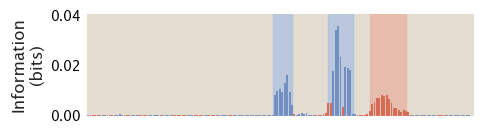

In [8]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
plot_footprint(promoter, df, region_params,
                fig_width=5, fig_height=1.5,
                outfile='../plots/fig1/info_footprint.pdf')

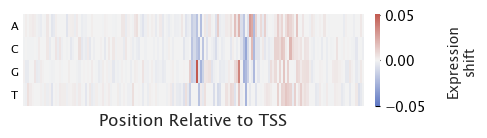

In [12]:
exshift = tregs.footprint.get_expression_shift_matrix(df, promoter)

fig, ax = plt.subplots(figsize=(5.5, 1.2))

vmax = np.max(np.abs(exshift))
vmin = -vmax

div_colors = sns.diverging_palette(258, 16, s=56, l=51, n=15, sep=2, center='light', as_cmap=True)
hm = sns.heatmap(exshift, cmap=div_colors, ax=ax, vmin=vmin, vmax=vmax,
                 xticklabels=False)
ax.set_yticklabels(['A', 'C', 'G', 'T'], rotation=360, fontsize=8)
ax.set_xlabel('Position Relative to TSS')

# Access the colorbar and modify its properties
cbar = hm.collections[0].colorbar
cbar.ax.set_position([ax.get_position().x1 + 0.02, ax.get_position().y0, 0.02, ax.get_position().height])
cbar.set_label('Expression\nshift', rotation=90, labelpad=15, fontsize=10)
cbar.ax.tick_params(labelsize=10) 

#plt.tight_layout()
plt.savefig('../plots/fig1/exshift_matrix.pdf', bbox_inches='tight')
plt.show()